[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle


In [ ]:
from google.colab import files
files.upload()
files

Saving kaggle.json to kaggle (1).json


<module 'google.colab.files' from '/usr/local/lib/python3.10/dist-packages/google/colab/files.py'>

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/shoes-classification-dataset-13k-images

shoes-classification-dataset-13k-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

with zipfile.ZipFile('/content/shoes-classification-dataset-13k-images.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os 

import cv2
from tqdm import tqdm

PATH = '/content/Shoes Dataset/Train'
classes = os.listdir(PATH)
classes

['Ballet Flat', 'Sneaker', 'Boat', 'Clog', 'Brogue']

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
    paths = [p for p in os.listdir(f'{PATH}/{lab}') if p.endswith('.jpeg') or p.endswith('.png')]
    print(f'Categoría: {lab}. Imágenes: {len(paths)}')
    imgs += [os.path.join(PATH, lab, img) for img in paths]
    labels += [i]*len(paths)

print(f'Total de imágenes: {len(imgs)}')
imgs[:5]

Categoría: Ballet Flat. Imágenes: 2000
Categoría: Sneaker. Imágenes: 2000
Categoría: Boat. Imágenes: 2000
Categoría: Clog. Imágenes: 2000
Categoría: Brogue. Imágenes: 2000
Total de imágenes: 10000


['/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (1200).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (1966).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (1654).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (962).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (1684).jpeg']

In [ ]:
len(imgs)

10000

Podemos visualizar algunas imágenes en el dataset.

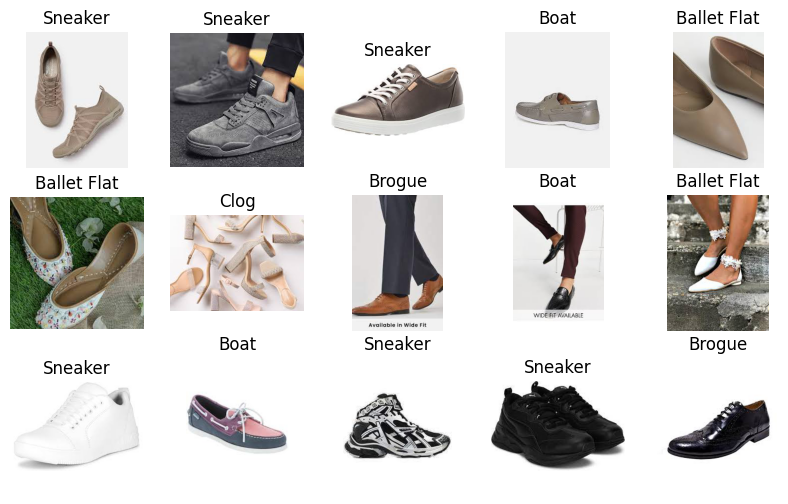

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)


(8000, 2000)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
from skimage import color
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    #hacemos que nuestras imagenes sena de 3 dimensiones 
    #borra la transparencia
    if img.shape[2] == 4:
      img= color.rgba2rgb(img)
    
      
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
img.shape

(237, 212, 3)

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(128, 128)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(8000, 2000)

In [ ]:
dataset['train'][2]

(tensor([[[0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          ...,
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255]],
 
         [[0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          ...,
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294],
          [0.9294, 0.9294, 0.9294,  ..., 0.9294, 0.9294, 0.9294]],
 
         [[0.9373, 0.9373, 0.9373,  ..., 0.9373, 0.9373, 0.9373],
          [0.9373, 0.9373, 0.9373,  ..., 0.9373, 0.9373, 0.9373],
          [0.9373, 0.9373, 0.9373,  ...,

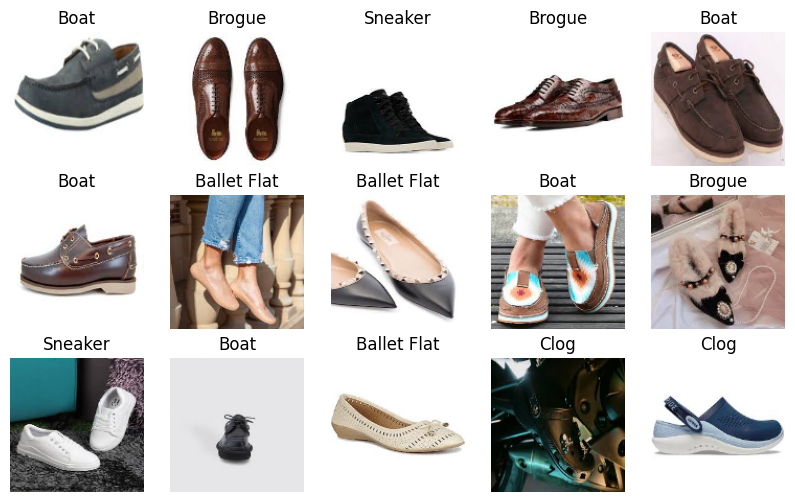

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 128, 128])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [ ]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [ ]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 128, 128))
outputs.shape


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [ ]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 1.57380 val_acc 0.31276: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch 1/15 loss 1.54903 val_loss 1.57380 acc 0.29425 val_acc 0.31276


val_loss 1.85671 val_acc 0.25454: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 2/15 loss 1.45366 val_loss 1.85671 acc 0.36338 val_acc 0.25454


val_loss 1.45970 val_acc 0.35543: 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch 3/15 loss 1.38535 val_loss 1.45970 acc 0.41513 val_acc 0.35543


val_loss 1.36169 val_acc 0.39900: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 4/15 loss 1.29993 val_loss 1.36169 acc 0.46963 val_acc 0.39900


val_loss 1.70939 val_acc 0.36009: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 5/15 loss 1.19894 val_loss 1.70939 acc 0.52712 val_acc 0.36009


val_loss 1.38629 val_acc 0.43033: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch 6/15 loss 1.08286 val_loss 1.38629 acc 0.58575 val_acc 0.43033


val_loss 2.71027 val_acc 0.32151: 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 7/15 loss 0.95047 val_loss 2.71027 acc 0.65200 val_acc 0.32151


val_loss 1.23291 val_acc 0.51698: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 8/15 loss 0.81153 val_loss 1.23291 acc 0.71362 val_acc 0.51698


val_loss 1.18845 val_acc 0.55867: 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 9/15 loss 0.65536 val_loss 1.18845 acc 0.78350 val_acc 0.55867


val_loss 2.03957 val_acc 0.39265: 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 10/15 loss 0.48469 val_loss 2.03957 acc 0.84550 val_acc 0.39265


val_loss 1.64861 val_acc 0.51052: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Epoch 11/15 loss 0.33865 val_loss 1.64861 acc 0.90012 val_acc 0.51052


val_loss 1.45181 val_acc 0.54905: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 12/15 loss 0.20443 val_loss 1.45181 acc 0.95137 val_acc 0.54905


val_loss 1.40054 val_acc 0.59135: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 13/15 loss 0.10910 val_loss 1.40054 acc 0.98137 val_acc 0.59135


val_loss 1.22374 val_acc 0.63976: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 14/15 loss 0.05955 val_loss 1.22374 acc 0.99162 val_acc 0.63976


val_loss 1.23830 val_acc 0.65418: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

Epoch 15/15 loss 0.03404 val_loss 1.23830 acc 0.99650 val_acc 0.65418


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

In [ ]:
# guardar modelo
PATH = './checkpoint_01.pt'
torch.save(model_c.state_dict(), PATH) 

In [ ]:
# cargar modelo
model_cero = ModelCustom()
model_cero.load_state_dict(torch.load(PATH))
model_cero.eval()

ModelCustom(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

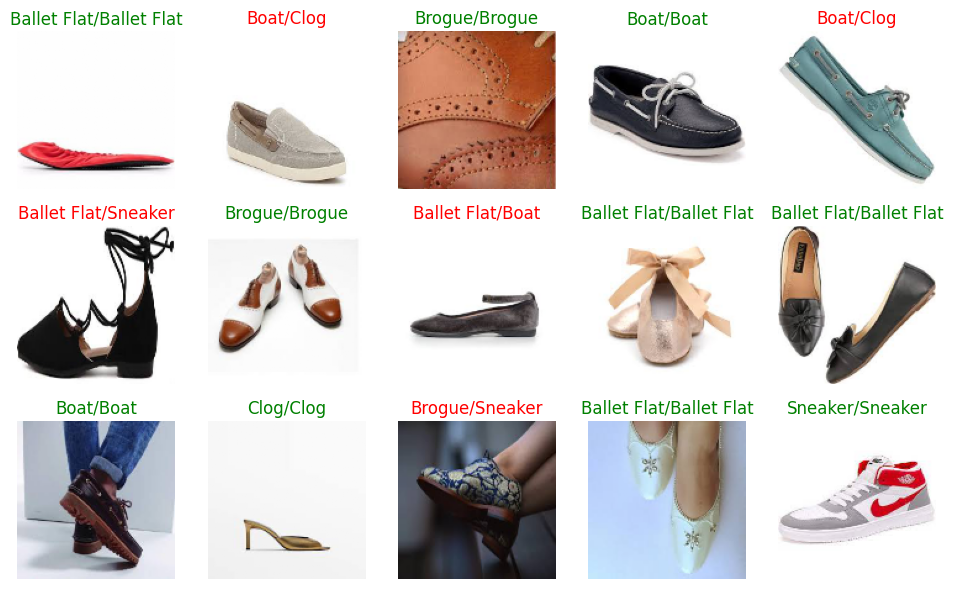

In [ ]:
plot_predictions(model_cero, dataloader, 3, 5)

In [ ]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fdbcd0efbe0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fdbcd0eec20>}

Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [ ]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]
val_loss 1.10338 val_acc 0.59135: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 1/5 loss 1.27834 val_loss 1.10338 acc 0.48387 val_acc 0.59135


val_loss 0.96859 val_acc 0.64825: 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch 2/5 loss 1.02747 val_loss 0.96859 acc 0.61575 val_acc 0.64825


val_loss 0.93036 val_acc 0.65907: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 3/5 loss 0.95885 val_loss 0.93036 acc 0.64538 val_acc 0.65907


val_loss 0.91616 val_acc 0.66493: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 4/5 loss 0.92584 val_loss 0.91616 acc 0.65612 val_acc 0.66493


val_loss 0.89542 val_acc 0.67409: 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

Epoch 5/5 loss 0.89620 val_loss 0.89542 acc 0.66963 val_acc 0.67409


In [ ]:
# guardar modelo
PATH = './checkpoint_Transfer_Learning.pt'
torch.save(model_c.state_dict(), PATH)

In [ ]:
# cargar modelo
model_Transfer = ModelCustom()
model_Transfer.load_state_dict(torch.load(PATH))
model_Transfer.eval()

ModelCustom(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

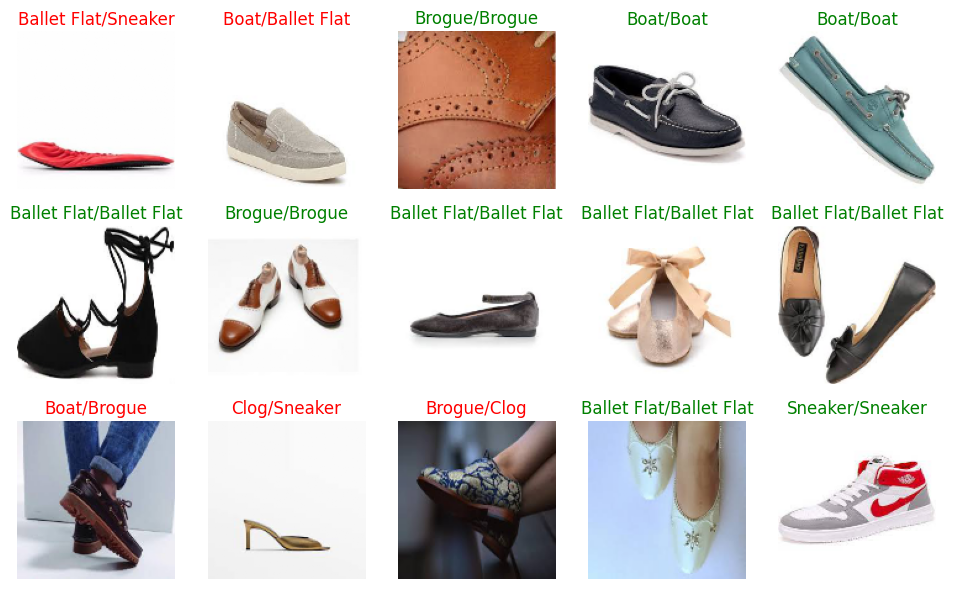

In [ ]:
plot_predictions(model_c, dataloader, 3, 5)

Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [ ]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 0.73381 val_acc 0.74388: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 1/5 loss 0.99636 val_loss 0.73381 acc 0.62238 val_acc 0.74388


val_loss 0.57502 val_acc 0.80499: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 2/5 loss 0.53537 val_loss 0.57502 acc 0.81700 val_acc 0.80499


val_loss 0.55938 val_acc 0.81231: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 3/5 loss 0.33847 val_loss 0.55938 acc 0.88962 val_acc 0.81231


val_loss 0.52104 val_acc 0.83327: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 4/5 loss 0.20648 val_loss 0.52104 acc 0.94325 val_acc 0.83327


val_loss 0.55125 val_acc 0.83105: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

Epoch 5/5 loss 0.11846 val_loss 0.55125 acc 0.97400 val_acc 0.83105


In [ ]:
# guardar modelo
PATH = './checkpoint_Fine_tuning.pt'
torch.save(model_c.state_dict(), PATH) 


In [ ]:
# cargar modelo
model_Fine_tuning= ModelCustom()
model_Fine_tuning.load_state_dict(torch.load(PATH))
model_Fine_tuning.eval()

ModelCustom(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

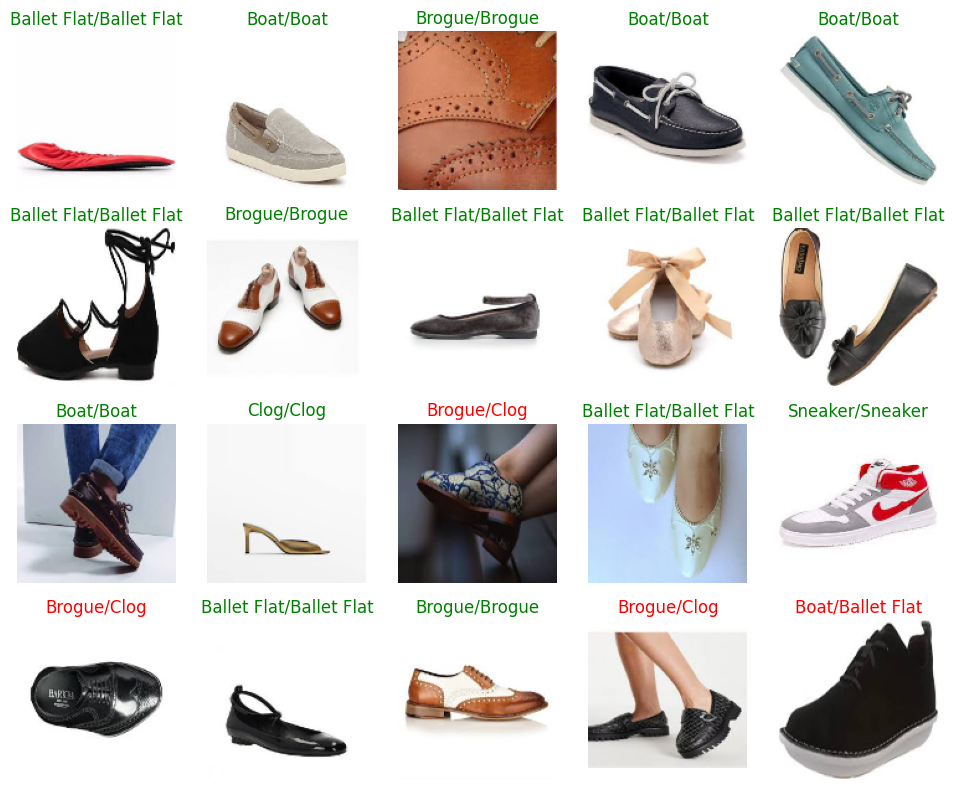

In [ ]:
plot_predictions(model_Fine_tuning, dataloader, 4, 5)

Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [ ]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 1.05879 val_acc 0.60975: 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 1/5 loss 1.27103 val_loss 1.05879 acc 0.48500 val_acc 0.60975


val_loss 0.96542 val_acc 0.64374: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 2/5 loss 1.00833 val_loss 0.96542 acc 0.62113 val_acc 0.64374


val_loss 0.94301 val_acc 0.64956: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 3/5 loss 0.95201 val_loss 0.94301 acc 0.64563 val_acc 0.64956


val_loss 0.90487 val_acc 0.67203: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 4/5 loss 0.91685 val_loss 0.90487 acc 0.66275 val_acc 0.67203


val_loss 0.89201 val_acc 0.67409: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


Epoch 5/5 loss 0.89100 val_loss 0.89201 acc 0.67000 val_acc 0.67409


val_loss 0.88032 val_acc 0.67894: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 1/5 loss 0.85956 val_loss 0.88032 acc 0.69225 val_acc 0.67894


val_loss 0.86948 val_acc 0.68078: 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 2/5 loss 0.84119 val_loss 0.86948 acc 0.69875 val_acc 0.68078


val_loss 0.85913 val_acc 0.68442: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 3/5 loss 0.82750 val_loss 0.85913 acc 0.70250 val_acc 0.68442


val_loss 0.85136 val_acc 0.69062: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 4/5 loss 0.81308 val_loss 0.85136 acc 0.70988 val_acc 0.69062


val_loss 0.84785 val_acc 0.69197: 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

Epoch 5/5 loss 0.81068 val_loss 0.84785 acc 0.70913 val_acc 0.69197


In [ ]:
# guardar modelo
PATH = './checkpoint_dos_Formas.pt'
torch.save(model_o.state_dict(), PATH) 


In [ ]:
# cargar modelo
model_o= ModelCustom()
model_o.load_state_dict(torch.load(PATH))


<All keys matched successfully>

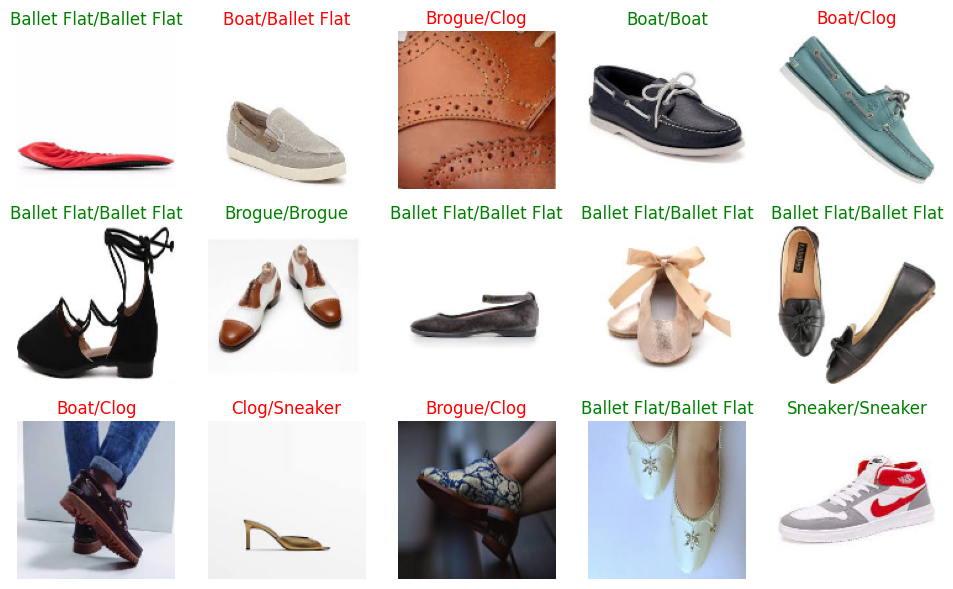

In [ ]:
plot_predictions(model_o, dataloader, 3, 5)

Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [ ]:
optimizer = torch.optim.Adam([
    {'params': model_o.resnet.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    optimizer = optimizer = torch.optim.Adam([{'params': model.resnet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
model_o.unfreeze()
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

val_loss 1.00897 val_acc 0.62707: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 1/5 loss 1.23230 val_loss 1.00897 acc 0.51050 val_acc 0.62707


val_loss 0.93117 val_acc 0.66372: 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch 2/5 loss 0.98142 val_loss 0.93117 acc 0.63550 val_acc 0.66372


val_loss 0.89895 val_acc 0.67785: 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch 3/5 loss 0.93482 val_loss 0.89895 acc 0.65012 val_acc 0.67785


val_loss 0.90054 val_acc 0.67454: 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 4/5 loss 0.89524 val_loss 0.90054 acc 0.67250 val_acc 0.67454


val_loss 0.86976 val_acc 0.68562: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 5/5 loss 0.88287 val_loss 0.86976 acc 0.67288 val_acc 0.68562


val_loss 0.51218 val_acc 0.83575: 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 1/5 loss 0.68122 val_loss 0.51218 acc 0.75613 val_acc 0.83575


val_loss 0.51360 val_acc 0.84142: 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 2/5 loss 0.16673 val_loss 0.51360 acc 0.94912 val_acc 0.84142


val_loss 0.53078 val_acc 0.84364: 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch 3/5 loss 0.03771 val_loss 0.53078 acc 0.99313 val_acc 0.84364


val_loss 0.56199 val_acc 0.84484: 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch 4/5 loss 0.01488 val_loss 0.56199 acc 0.99762 val_acc 0.84484


val_loss 0.56278 val_acc 0.86080: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

Epoch 5/5 loss 0.00728 val_loss 0.56278 acc 0.99875 val_acc 0.86080


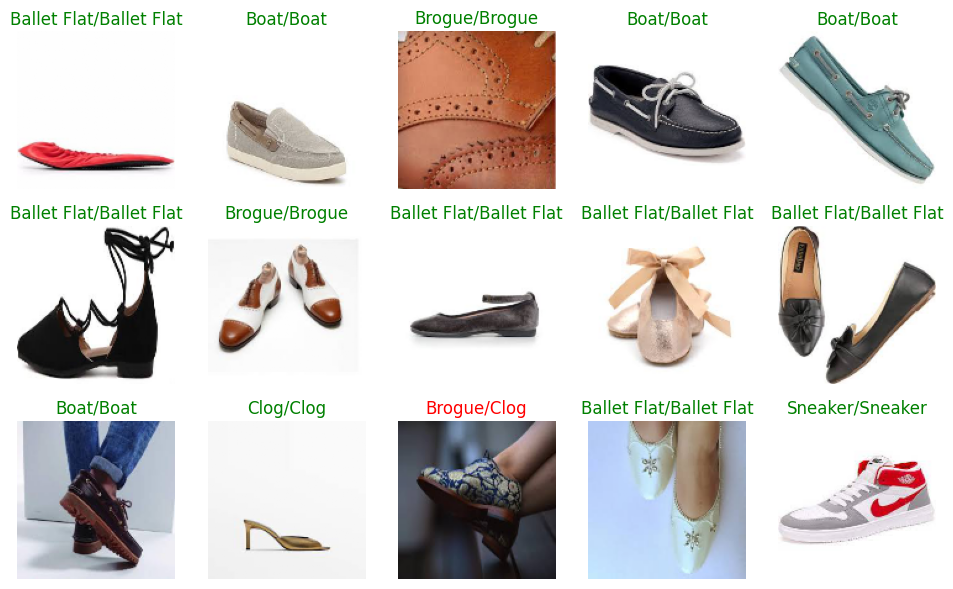

In [ ]:
plot_predictions(model_o, dataloader, 3, 5)

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.